# Notebook 4: Linear Regression (Ising)

### Exercises: ###  
<ul>
<li> Plot a histogram of the distribution of the components of ${\bf J}$ at different values of the number of training sample (one can go up to $2\times 10^4$). What happens with the sampling noise as the number of samples is increased/decreased for the three types of regression considered? How do the matrix elements plots above change?

<li> Try to learn the underlying model of the data, assuming it lies within the class of one-body Hamiltonians, i.e. make the ansatz 
$$H_\mathrm{model}[\boldsymbol{S}^i] = \sum_{j=1}^L h_jS_{j}$$
for some unknown field $h_j$. How well can you explain the data? How well does the model generalize? Study these problems by playing with the size of the data set. Try out all three regression models and determine which one does the best. What is the relationship to Mean-Field Theory of this model?
</ul>

Mehta Ising Code:

In [2]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(12000,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E

In [3]:
# calculate Ising energies
energies=ising_energies(states)

# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

#### 1. Plot a histogram of the distribution of the components of ${\bf J}$ at different values of the number of training sample (one can go up to $2\times 10^4$). What happens with the sampling noise as the number of samples is increased/decreased for the three types of regression considered? How do the matrix elements plots above change? ####

I'm going to pick a single value of $\lambda$ (in the performance plot, $2 \times 10^{-3}$ looks good) to keep the number of plots reasonable.

100


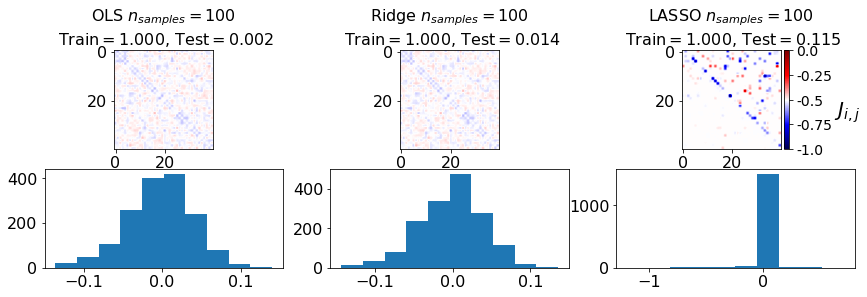

316


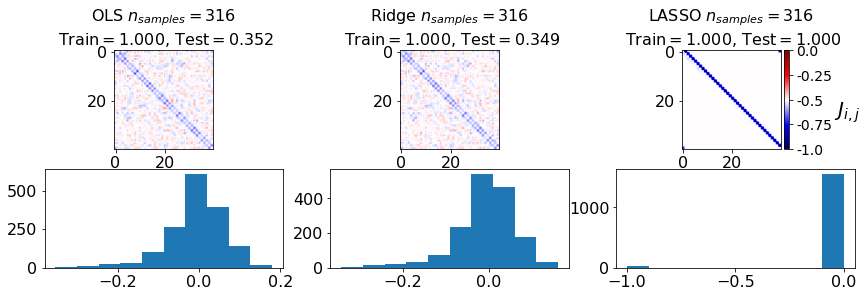

1000


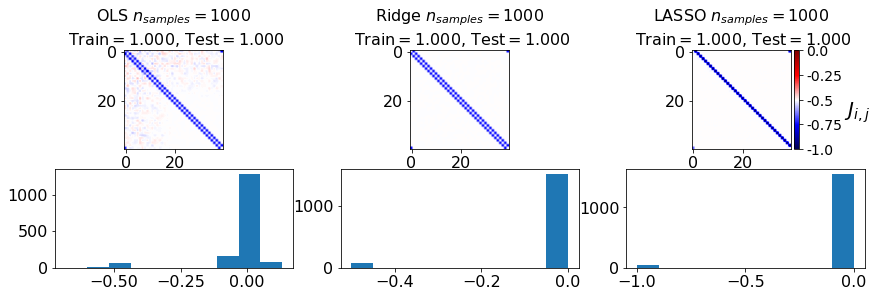

3162


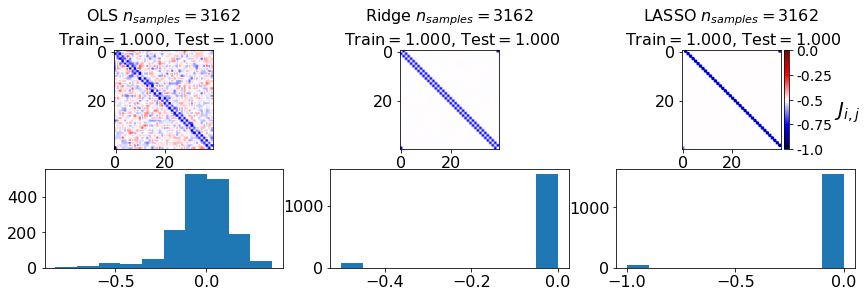

9999


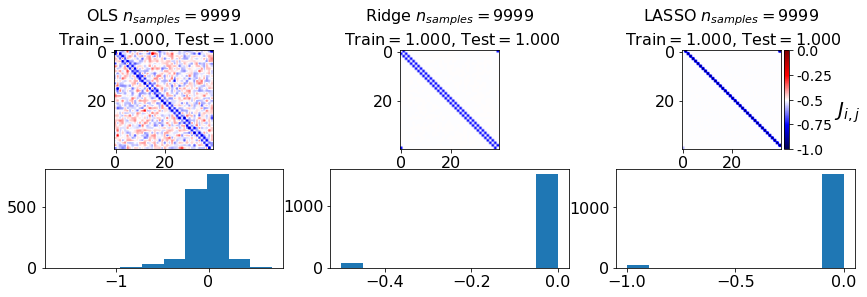

In [5]:
# Modified Mehta Code:

from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength value
lmbda = 2.0e-3

# Set number of samples array
n_samples_a = np.logspace(2, 4, 5) # Will set to an integer later

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for n_samples in n_samples_a:
    
    n_samples = int(n_samples) # n_samples obviously has to be an integer
    if n_samples == 10000: n_samples = 9999
    print(n_samples)
    
    # define train and test data sets
    X_train=Data[0][:n_samples]
    Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
    X_test=Data[0][n_samples:3*n_samples//2]
    Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=2, ncols=3)
    
    axarr[0,0].imshow(J_leastsq,**cmap_args)
    axarr[0,0].set_title('OLS $n_{samples}=%.d$ \n Train$=%.3f$, Test$=%.3f$'%(n_samples, train_errors_leastsq[-1], test_errors_leastsq[-1]),fontsize=16)
    axarr[0,0].tick_params(labelsize=16)
    
    axarr[1,0].hist(np.reshape(J_leastsq, J_leastsq.size))
    axarr[1,0].tick_params(labelsize=16)
    
    axarr[0,1].imshow(J_ridge,**cmap_args)
    axarr[0,1].set_title('Ridge $n_{samples}=%.d$\n Train$=%.3f$, Test$=%.3f$' %(n_samples,train_errors_ridge[-1],test_errors_ridge[-1]),fontsize=16)
    axarr[0,1].tick_params(labelsize=16)
    
    axarr[1,1].hist(np.reshape(J_ridge, J_ridge.size))
    axarr[1,1].tick_params(labelsize=16)
    
    im=axarr[0,2].imshow(J_lasso,**cmap_args)
    axarr[0,2].set_title('LASSO $n_{samples}=%.d$\n Train$=%.3f$, Test$=%.3f$' %(n_samples,train_errors_lasso[-1],test_errors_lasso[-1]),fontsize=16)
    axarr[0,2].tick_params(labelsize=16)
    
    axarr[1,2].hist(np.reshape(J_lasso, J_lasso.size))
    axarr[1,2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[0,2])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

#### Plot Comments: ####

All models benefit from more training examples (except for some strange behaviour in OLS for large $n_{samples}$ - I have no idea what is causing this). As can be seen in both the histograms and the imshow plots, there is less noise in the model when there are larger training examples (where by noise I mean nonzero off-diagonal elements that should be zero). As expected, LASSO is especially good even with a small number of training samples, the reason being that it prefers to set weights to 0. The noise in Ridge vanishes with a larger training set, and the noise in OLS vanishes for a training set that is greater still. This is of course due to the fact that Ridge constrains the size of the weights, so it has a tendency to set weights to small values before OLS.

I have no idea what's going on in OLS at high training sample size. It should perform better the bigger the training set. My guess is that there is some bug in the code, and that the above OLS results aren't actually for large training sets.

#### 2. Try to learn the underlying model of the data, assuming it lies within the class of one-body Hamiltonians, i.e. make the ansatz ####
$$H_\mathrm{model}[\boldsymbol{S}^i] = \sum_{j=1}^L h_jS_{j}$$ 
#### for some unknown field $h_j$. How well can you explain the data? How well does the model generalize? Study these problems by playing with the size of the data set. Try out all three regression models and determine which one does the best. What is the relationship to Mean-Field Theory of this model? ####

100
316
1000
3162
10000


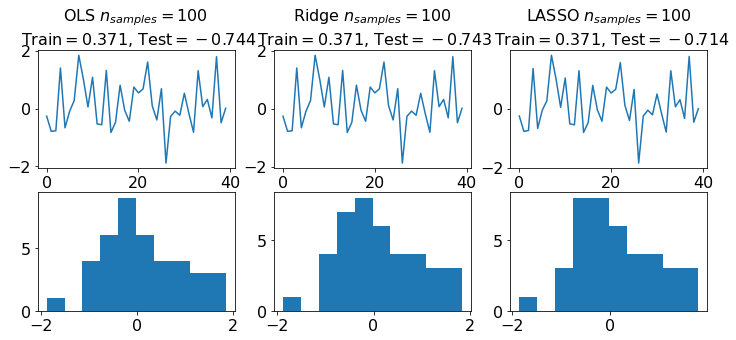

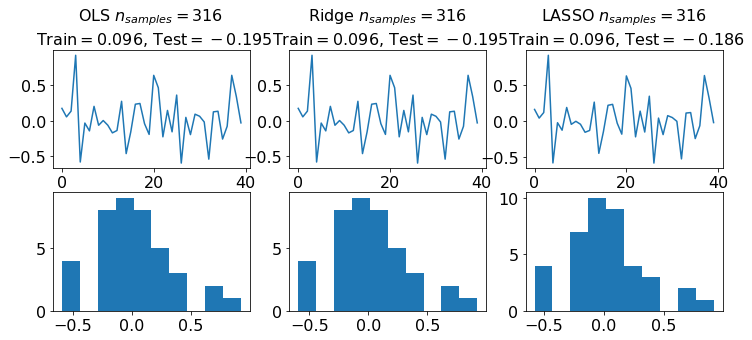

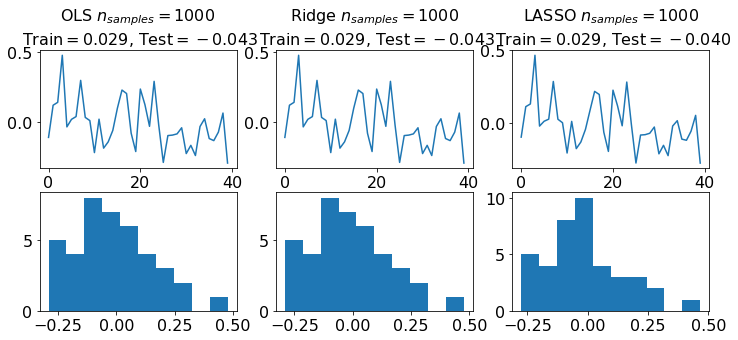

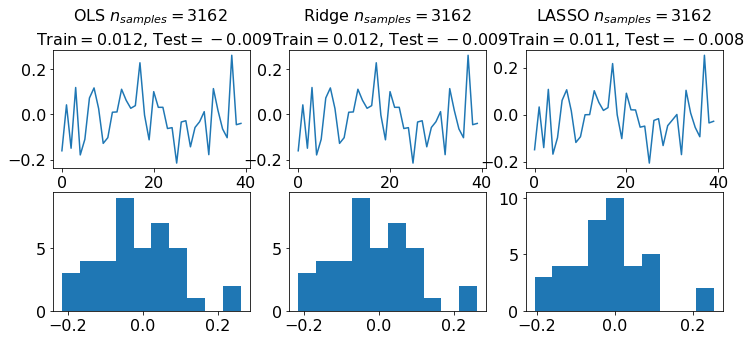

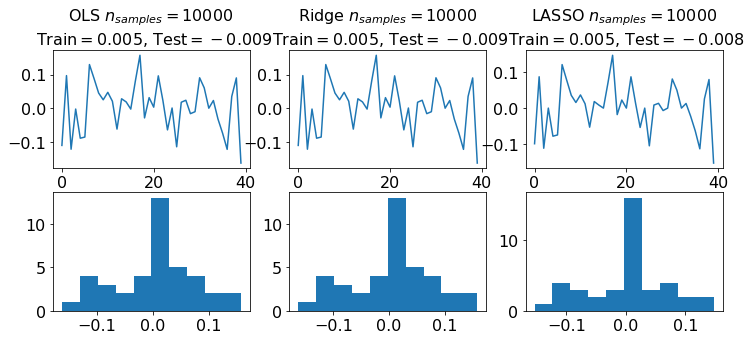

In [37]:
# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(12000,L))

# calculate Ising energies
energies=ising_energies(states)

# build final data set
Data=[states,energies]

from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength value
lmbda = 1.0e-2
#lmbdas = np.logspace(-4, 5, 10)

# Set number of samples array
n_samples_a = np.logspace(2, 4, 5) # Will set to an integer later

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for n_samples in n_samples_a:
    
    n_samples = int(n_samples) # n_samples obviously has to be an integer
    print(n_samples)
    
    # define train and test data sets
    X_train=Data[0][:n_samples]
    Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
    X_test=Data[0][n_samples:3*n_samples//2]
    Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_)
    J_ridge=np.array(ridge.coef_)
    J_lasso=np.array(lasso.coef_)
    
    fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12,4.8))
    
    
    axarr[0,0].plot(J_leastsq)
    axarr[0,0].set_title('OLS $n_{samples}=%.d$ \n Train$=%.3f$, Test$=%.3f$'%(n_samples, train_errors_leastsq[-1], test_errors_leastsq[-1]),fontsize=16)
    axarr[0,0].tick_params(labelsize=16)
    
    axarr[1,0].hist(J_leastsq)
    axarr[1,0].tick_params(labelsize=16)
    
    axarr[0,1].plot(J_ridge)
    axarr[0,1].set_title('Ridge $n_{samples}=%.d$\n Train$=%.3f$, Test$=%.3f$' %(n_samples,train_errors_ridge[-1],test_errors_ridge[-1]),fontsize=16)
    axarr[0,1].tick_params(labelsize=16)
    
    axarr[1,1].hist(J_ridge)
    axarr[1,1].tick_params(labelsize=16)
    
    axarr[0,2].plot(J_lasso)
    axarr[0,2].set_title('LASSO $n_{samples}=%.d$\n Train$=%.3f$, Test$=%.3f$' %(n_samples,train_errors_lasso[-1],test_errors_lasso[-1]),fontsize=16)
    axarr[0,2].tick_params(labelsize=16)
    
    axarr[1,2].hist(J_lasso)
    axarr[1,2].tick_params(labelsize=16)

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

The model tends to find parameters values near 0. This makes sense considering the model's connection to mean field theory. According to Wikipedia, MFT "studies the behavior of high-dimensional random (stochastic) models by studying a simpler model that approximates the original by averaging over degrees of freedom". Here, the degree of freedom averaged over is the spin's neighbour. Instead of multiplying a spin by its neighbour, the model only contains spin itself. In other words, it has averaged over the nieghbouring spin, with the average being the weight $h_i$. On average, the nieghbour will have 0 spin (since it has a 50% chance of being both -1 and +1). As such, as the training set gets bigger, the model learns that all of the coefficients are 0 (which is the best it can do).

I would expect LASSO to do this best because it prefers to set things to 0, but it only has marginally more 0 weights than the other two models. This is probably because I used a small value of $\lambda$.

This mean field approximation tells us that on average, we expect the energy to be 0.

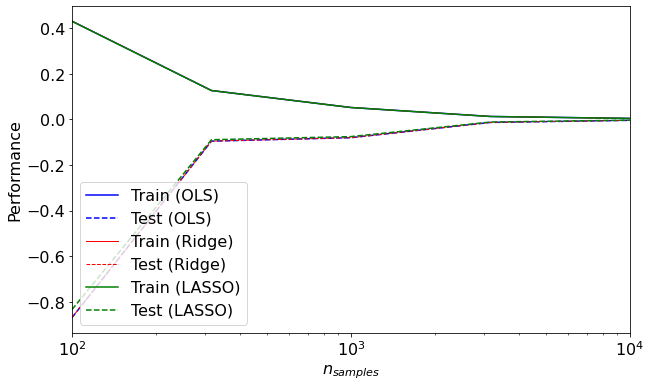

In [35]:
# Plot our performance on both the training and test data
plt.semilogx(n_samples_a, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(n_samples_a, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(n_samples_a, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(n_samples_a, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(n_samples_a, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(n_samples_a, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
#plt.ylim([-0.1, 1.1])
plt.xlim([min(n_samples_a), max(n_samples_a)])
plt.xlabel(r'$n_{samples}$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

The model performs terrbily on the test data. It's possible that there is some bug in my code, but I wouldn't surprised if these are genuine results because the model is far from the true model.

In [ ]:
ADR: 2/2